In [1]:
!pip install --upgrade setuptools pip --user
!pip install onnx
!pip install onnxruntime
#!pip install --ignore-installed PyYAML
#!pip install Pillow

!pip install protobuf<4.21.3
!pip install onnxruntime-gpu
!pip install onnx>=1.9.0
!pip install onnx-simplifier>=0.3.6 --user

/bin/bash: line 1: 4.21.3: No such file or directory


In [2]:
import sys
import torch
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0], sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0) 
Pytorch version: 2.5.0+cu121 


# 以下是推論修改後的 onnx 檔

In [5]:
import onnx
import onnxruntime
import numpy as np
import cv2
import sys
from PIL import Image
import time


# 80 COCO classes
CLASSES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
           'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
           'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
           'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
           'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
           'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
           'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
           'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
           'hair drier', 'toothbrush']

## Self-defined classes
# meta = sess.get_modelmeta().custom_metadata_map
# print( meta )

def load_onnx(onnx_path):
    onnx_model = onnx.load(onnx_path)
    try:
        onnx.checker.check_model(onnx_model)
    except Exception:
        print("Model incorrect")
    else:
        print("Model correct")

    options = onnxruntime.SessionOptions()
    sess = onnxruntime.InferenceSession(onnx_path,
                                        providers=['CPUExecutionProvider'])
    # 'CUDAExecutionProvider',
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    print(input_name,output_name)
    return sess,input_name,output_name


def onnx_inference(sess,input_name,output_name,data):

    pred_onnx = sess.run([output_name], {input_name: data})
    return pred_onnx


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
 	# Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)


def box_iou(box1, box2, eps=1e-7):
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (np.min(a2, b2) - np.max(a1, b1)).clamp(0).prod(2)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

def nms_boxes(boxes, scores):

    x = boxes[:, 0]
    y = boxes[:, 1]
    w = boxes[:, 2] - boxes[:, 0]
    h = boxes[:, 3] - boxes[:, 1]

    areas = w * h
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x[i], x[order[1:]])
        yy1 = np.maximum(y[i], y[order[1:]])
        xx2 = np.minimum(x[i] + w[i], x[order[1:]] + w[order[1:]])
        yy2 = np.minimum(y[i] + h[i], y[order[1:]] + h[order[1:]])

        w1 = np.maximum(0.0, xx2 - xx1 + 0.00001)
        h1 = np.maximum(0.0, yy2 - yy1 + 0.00001)
        inter = w1 * h1

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= 0.45)[0]

        order = order[inds + 1]
    keep = np.array(keep)
    return keep

def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nm=0,  # number of masks
):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections
    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    if isinstance(prediction, (list, tuple)):  # YOLOv7 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - nm - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates


    # Settings
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    mi = 5 + nc  # mask start index
    output = [np.zeros((0, 6 + nm))] * bs

    for xi, x in enumerate(prediction):  # image index, image inference
        x = x[xc[xi]]  # confidence
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = np.zeros(len(lb), nc + nm + 5)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = np.concatenate((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box/Mask
        box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        mask = x[:, mi:]  # zero columns if no masks

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
            x = np.concatenate((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)

        else:  # best class only
            conf = np.max(x[:, 5:mi], 1).reshape(box.shape[:1][0], 1)
            j = np.argmax(x[:, 5:mi], 1).reshape(box.shape[:1][0], 1)
            x = np.concatenate((box, conf, j, mask), 1)[conf.reshape(box.shape[:1][0]) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == np.array(classes, device=x.device)).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        index = x[:, 4].argsort(axis=0)[:max_nms][::-1]
        x = x[index]

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = nms_boxes(boxes, scores)
        i = i[:max_det]  # limit detections

        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = np.multiply(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]

    return output

def clip_boxes(boxes, shape):
    # Clip boxes (xyxy) to image shape (height, width)

    boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2

def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None):
    # Rescale boxes (xyxy) from img1_shape to img0_shape
    # calculate from img0_shape
    if ratio_pad is None:
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    boxes[..., [0, 2]] -= pad[0]  # x padding
    boxes[..., [1, 3]] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    clip_boxes(boxes, img0_shape)
    return boxes



def draw(image, box_data):
    boxes = box_data[..., :4].astype(np.int32)  # x1 x2 y1 y2
    scores = box_data[..., 4]
    classes = box_data[..., 5].astype(np.int32)
    for box, score, cl in zip(boxes, scores, classes):
        top, left, right, bottom = box
        print('class: {}, score: {}'.format(CLASSES[cl], score))
        print('box coordinate left,top,right,down: [{}, {}, {}, {}]'.format(top, left, right, bottom))

        cv2.rectangle(image, (top, left), (right, bottom), (255, 0, 0), 2)
        cv2.putText(image, '{0} {1:.2f}'.format(CLASSES[cl], score),
                    (top, left),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 0, 255), 2)
    return image


def main():
    onnx_path = "./version3.onnx"
    img_path = "./car.jpg"

    sess,input_name,output_name = load_onnx(onnx_path)
    imgsz = (640, 640)
    img = cv2.imread(img_path)
    print(img.shape)
    # preprocess
    im = letterbox(img, new_shape=imgsz, auto=False)[0]  # padded resize
    im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    im = np.ascontiguousarray(im)  # contiguous
    im = im.astype(np.float32)
    im /= 255  # 0 - 255 to 0.0 - 1.0

    if len(im.shape) == 3:
        im = np.expand_dims(im, axis=0)

    # im =  im.reshape(1, 3, 640, 640).astype(np.float32)
    pred = onnx_inference(sess,input_name,output_name, im)

    # NMS
    conf_thres = 0.35  # confidence threshold
    iou_thres = 0.65  # NMS IOU threshold
    max_det = 640  # maximum detections per image
    classes = None  # filter by class: --class 0, or --class 0 2 3
    agnostic_nms = False  # class-agnostic NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)


    # Process predictions
    seen = 0
    for i, det in enumerate(pred):
        seen += 1
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], img.shape).round()
    # print(pred)
    outputs = pred[0][:, :6]

    draw(img,outputs)
    cv2.imwrite('./car_output_onnx.jpg', img)

    return


if __name__ == "__main__":
    main()


Model correct
images /model/model.77/Concat_3_output_0
(437, 656, 3)
class: car, score: 0.7654709815979004
box coordinate left,top,right,down: [579, 387, 638, 430]
class: car, score: 0.7206323742866516
box coordinate left,top,right,down: [158, 310, 196, 340]
class: car, score: 0.7183452248573303
box coordinate left,top,right,down: [130, 263, 163, 288]
class: car, score: 0.7074490189552307
box coordinate left,top,right,down: [282, 291, 320, 321]
class: car, score: 0.7036445140838623
box coordinate left,top,right,down: [83, 230, 113, 256]
class: car, score: 0.6845206022262573
box coordinate left,top,right,down: [90, 193, 119, 223]
class: car, score: 0.6723431944847107
box coordinate left,top,right,down: [43, 206, 70, 229]
class: car, score: 0.661030650138855
box coordinate left,top,right,down: [601, 359, 653, 397]
class: car, score: 0.6306519508361816
box coordinate left,top,right,down: [471, 376, 523, 413]
class: car, score: 0.6077011227607727
box coordinate left,top,right,down: [254, 2

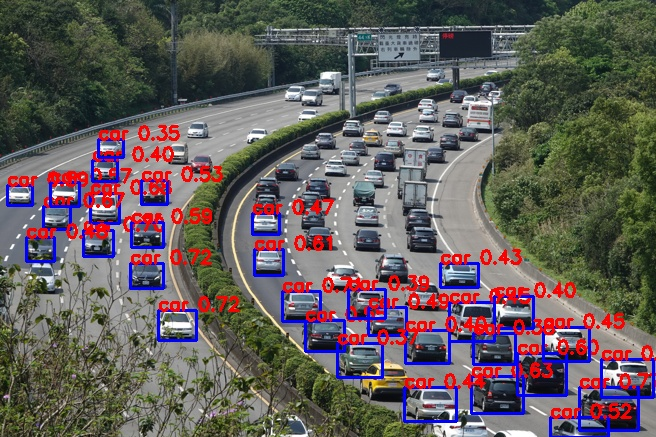

In [6]:
Image.open('./car_output_onnx.jpg')

# 以下是驗證 IPCAM 的推論輸出 bin 檔

In [7]:
import numpy as np

def read_bin_as_float(filename):
    with open(filename, "rb") as f:
        data = np.fromfile(f, dtype=np.float32)

    data = data.reshape((1, 25200, 85))
    return data

filename = "./output_car2.bin"
pred = read_bin_as_float(filename)

for i in range(85):
  print(pred[0][10000][i])

img_path = "./car2_640.jpg"
imgsz = (640, 640)
img = cv2.imread(img_path)
print(img.shape)
# preprocess
im = letterbox(img, new_shape=imgsz, auto=False)[0]  # padded resize
im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
im = np.ascontiguousarray(im)  # contiguous
im = im.astype(np.float32)
im /= 255  # 0 - 255 to 0.0 - 1.0

if len(im.shape) == 3:
  im = np.expand_dims(im, axis=0)

# NMS
conf_thres = 0.35  # confidence threshold
iou_thres = 0.65  # NMS IOU threshold
max_det = 640  # maximum detections per image
classes = None  # filter by class: --class 0, or --class 0 2 3
agnostic_nms = False  # class-agnostic NMS
pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# Process predictions
seen = 0
for i, det in enumerate(pred):
  seen += 1
  if len(det):
      # Rescale boxes from img_size to im0 size
      det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], img.shape).round()
# print(pred)
outputs = pred[0][:, :6]


draw(img,outputs)
cv2.imwrite('./car2_640_output_bin.jpg', img)

6.875
362.04688
14.546875
20.25
0.0
0.078125
0.0625
0.734375
0.03125
0.0
0.0
0.0
0.015625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
(640, 640, 3)
class: car, score: 0.90625
box coordinate left,top,right,down: [583, 317, 640, 403]
class: car, score: 0.89208984375
box coordinate left,top,right,down: [2, 348, 94, 508]
class: car, score: 0.875
box coordinate left,top,right,down: [0, 217, 66, 327]
class: car, score: 0.84765625
box coordinate left,top,right,down: [417, 294, 495, 369]
class: car, score: 0.845947265625
box coordinate left,top,right,down: [77, 297, 143, 391]
class: car, score: 0.815185546875
box coordinate left,top,right,down: [185, 516, 332, 634]
class: car, score: 0.7998046875
box coordinate left,top,right,down: [1, 167, 47, 225]

True

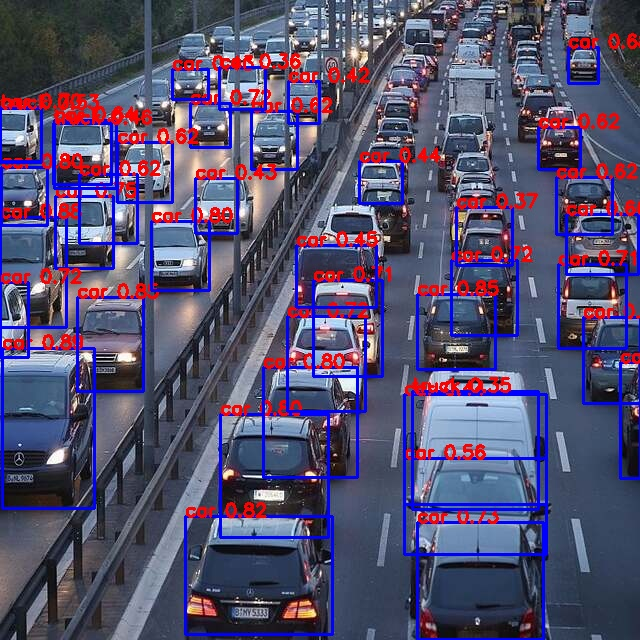

In [8]:
Image.open('./car2_640_output_bin.jpg')